# Part 2 - Extension Analysis
This notebook consists of part 2 of the course project. Part 2 is the extension analysis - expanding on our smoke estimate from part 1 with additional data.

In our case, we extend our part 1 analysis with health data on asthma and hypertension prevalence from the CDC.

## Packages
Import relevant packages to process and analyze the data.

In [123]:
import polars as pl
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler


# Exploratory Data Analysis
This section consists of some basic exploratory data analysis of the BRFSS data in the fire years we have from part 1.

Load and process the BRFSS data from the CDC and output an intermediary file for downstream use.

In [112]:
path = "./data/BRFSS/"

brfss_df = pl.DataFrame()
for file in os.listdir(path):
    df = pl.read_csv(path + file)
    df = df.filter(
        pl.col("Locationdesc") == "New York"
    )
    if brfss_df.is_empty():
        brfss_df = df.clone()
    else:
        brfss_df = pl.concat([brfss_df, df])

brfss_df.write_csv("./processed_data/bfrss_ny_health_outcomes.csv")
brfss_df.columns

['Year',
 'Locationabbr',
 'Locationdesc',
 'Class',
 'Topic',
 'Question',
 'Response',
 'Break_Out',
 'Break_Out_Category',
 'Sample_Size',
 'Data_value',
 'Confidence_limit_Low',
 'Confidence_limit_High',
 'Display_order',
 'Data_value_unit',
 'Data_value_type',
 'Data_Value_Footnote_Symbol',
 'Data_Value_Footnote',
 'DataSource',
 'ClassId',
 'TopicId',
 'LocationID',
 'BreakoutID',
 'BreakOutCategoryID',
 'QuestionID',
 'ResponseID',
 'GeoLocation']

Import the smoke estimate data from part 1.

In [113]:
wildfire_df = pl.read_csv("./processed_data/usgs_rochester_impact_per_year.csv")
wildfire_df

Fire_Year,Total_Acres_Burned,Avg_Smoke_Impact
i64,f64,f64
1971,404.113567,14.752245
1968,928.378622,41.916399
1974,166.368367,4.472671
1980,24778.945926,49.607314
1977,2629.969756,97.510863
…,…,…
2006,32952.900213,80.812526
2003,20138.382788,58.387924
2018,87626.618064,85.567839


Merge the smoke estimate data with the BRFSS health data.

Then filter for the selected health outcomes of asthma and high blood pressure.

In [114]:
combined_data = wildfire_df.join(
    brfss_df, left_on=["Fire_Year"], right_on=["Year"]
)


vars_to_examine = [
    #"SEV_scalar_inj_foreign_aspiration", 
    "Asthma",
    "High Blood Pressure",
    #"Cardiovascular Disease"
]
combined_data = combined_data.filter(
    pl.col("Topic").is_in(vars_to_examine)
)
combined_data = combined_data.to_pandas()


Now for some exploratory data analysis:

For the overall group lets observe how asthma and high blood pressure prevalence has changed over time.

Analyzing variable: Asthma
At age group: Overall


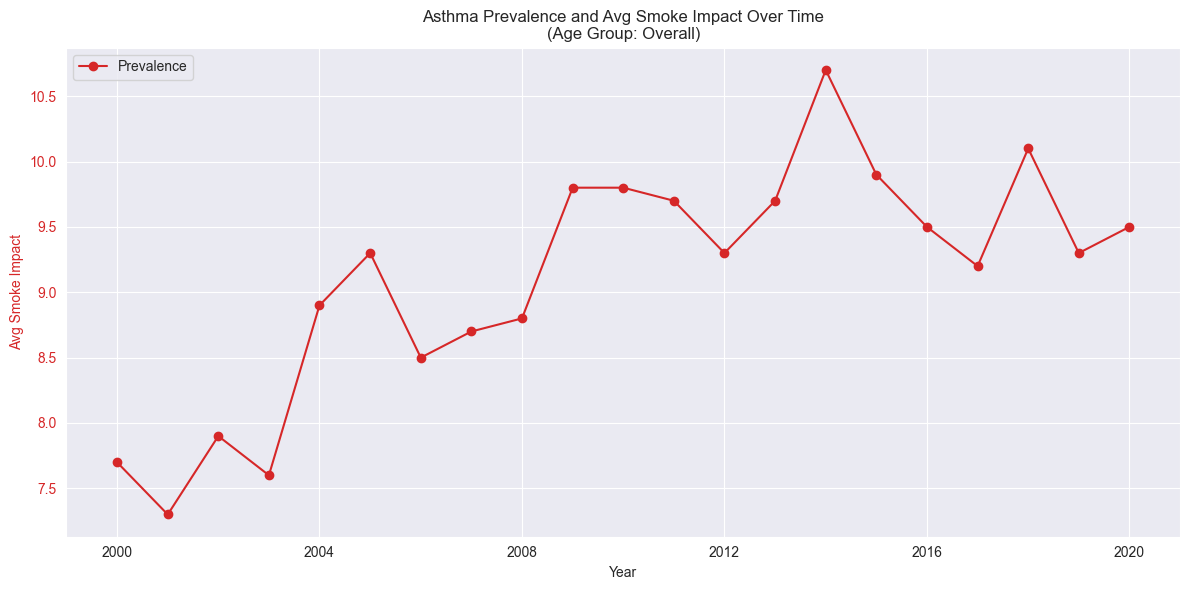

Analyzing variable: High Blood Pressure
At age group: Overall


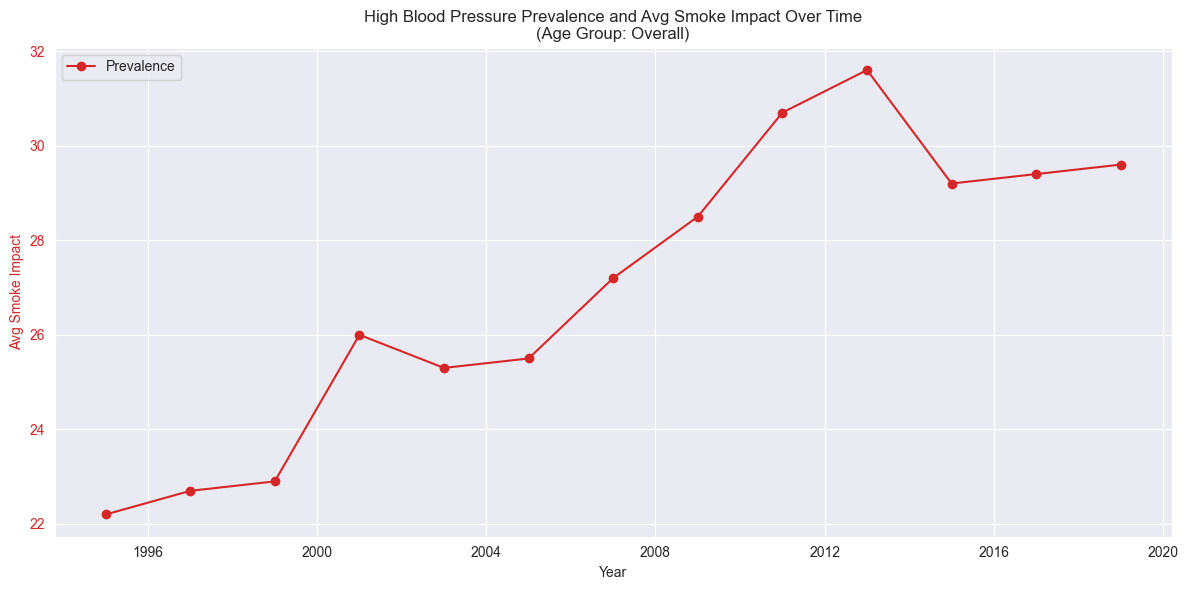

In [137]:
for var in combined_data['Topic'].unique():
    print(f"Analyzing variable: {var}")
    var_data = combined_data[combined_data['Topic'] == var]
    var_data = var_data[var_data['Response'] == 'Yes']

    if var == "Asthma":
        var_data = var_data[var_data["Question"] == "Adults who have been told they currently have asthma (variable calculated from one or more BRFSS questions)"]

    for age_group in ["Overall"]:#age_groups:
        print(f"At age group: {age_group}")
        age_var_data = var_data[var_data['Break_Out'] == age_group]

        if age_var_data.empty:
            continue

        # Merge with wildfire data
        merged_df = pd.merge(
            wildfire_df.to_pandas()[['Fire_Year', 'Avg_Smoke_Impact']],
            age_var_data[['Fire_Year', 'Data_value']],
            on='Fire_Year',
            how='inner'
        )

        merged_df = merged_df.rename(columns={'Data_value': 'Prevalence'})
        merged_df = merged_df.sort_values('Fire_Year')

        merged_df["Fire_Year"] = pd.to_datetime(merged_df["Fire_Year"], format="%Y")

        # Plotting over time
        fig, ax1 = plt.subplots(figsize=(12, 6))
        color = 'tab:red'
        ax1.set_xlabel('Year')
        ax1.set_ylabel('Avg Smoke Impact', color=color)
        ax1.plot(merged_df['Fire_Year'], merged_df['Prevalence'], color=color, marker='o', label='Prevalence')
        ax1.tick_params(axis='y', labelcolor=color)
 
        # ax2 = ax1.twinx()
        # color = 'tab:blue'
        # ax2.set_ylabel('Prevalence (%)', color=color)
        # ax2.plot(merged_df['Fire_Year'], merged_df['Normalized_Prevalence'], color=color, marker='s', label='Normalized Prevalence')
        # ax2.tick_params(axis='y', labelcolor=color)

        plt.title(f'{var} Prevalence and Avg Smoke Impact Over Time\n(Age Group: {age_group})')
        fig.tight_layout()
        ax1.legend(loc='upper left')
        # ax2.legend(loc='upper right')
        plt.grid(True)
        plt.show()

## Data Analysis
This section contains the code used to perform our analysis to answer our two research questions:
- (1) Are there any statistically significant associations between our smoke estimation and the prevalence of asthma and high blood pressure for the communities in Rochester, New York amongst all age groups?
- (2) What is the projected prevalence of asthma and high blood pressure for the next 10 years based on the smoke estimation for Rochester, New York communities amongst all age groups?


First, we import the processed smoke estimate data from part 1. Then we use the previous ARIMA model from part 1 to get the forecasted smoke estimate values for the next 10 years.

In [115]:
START_YEAR = 1961
END_YEAR = 2021

usgs_df = pl.read_csv('./processed_data/usgs_rochester_impact_per_year.csv')

# Join on all years to check if all years between 1961 and 2021 have some data.
all_years = pl.DataFrame({"Fire_Year": np.arange(START_YEAR, END_YEAR)})
usgs_df = all_years.join(usgs_df, on=["Fire_Year"], how="left", coalesce=True)
usgs_df = usgs_df.to_pandas()  # convert to pandas dataframe for statsmodels compatibility

usgs_df["Fire_Year"] = pd.to_datetime(usgs_df["Fire_Year"], format="%Y")
usgs_df = usgs_df.set_index("Fire_Year").asfreq("YS")

usgs_df

,Total_Acres_Burned,Avg_Smoke_Impact
Fire_Year,,
1961-01-01,151.680296,4.903111
1962-01-01,2029.271889,184.295457
1963-01-01,332.572086,31.522867
1964-01-01,13.925943,1.000000
1965-01-01,54.225598,2.825530
1966-01-01,45.216705,2.042889
1967-01-01,573.301900,51.064595
1968-01-01,928.378622,41.916399
1969-01-01,323.862625,6.143684


Here we define the ARIMA model from part 1 to forecast smoke estimates for the next 10 years.

In [116]:
# Define ARIMA model parameters
q = 1
d = 0
p = 1

# Fit the ARIMA model on 'Avg_Smoke_Impact'
model = ARIMA(usgs_df["Avg_Smoke_Impact"], order=(q, d, p))
model_fit = model.fit()

In [117]:
# Define the number of years to forecast
forecast_steps = 10

# Get the last year from the USGS data
last_year = usgs_df.reset_index()['Fire_Year'].dt.year.max()

# Generate future years
forecast_years = [last_year + i for i in range(1, forecast_steps + 1)]

# Forecast future smoke estimates
smoke_forecast = model_fit.get_forecast(steps=forecast_steps)
smoke_forecast_mean = smoke_forecast.predicted_mean
smoke_forecast_conf_int = smoke_forecast.conf_int()

forecast_df = pd.DataFrame({
    'Fire_Year': forecast_years,
    'Forecasted_Avg_Smoke_Impact': smoke_forecast_mean.values,
    'Lower_CI_Smoke': smoke_forecast_conf_int.iloc[:, 0].values,
    'Upper_CI_Smoke': smoke_forecast_conf_int.iloc[:, 1].values
})

We then take our merged data from our EDA - which contains the smoke estimate and health outcomes and concat it with our predicted smoke estimate.

We then fit use a Linear Regression model using `statsmodels` to predict the health outcome prevalence for each age group based on the forecasted smoke estimate.

We also can analyze the association between smoke estimate and health outcome with the regression.

Analyzing variable: Asthma
At age group: 18-24


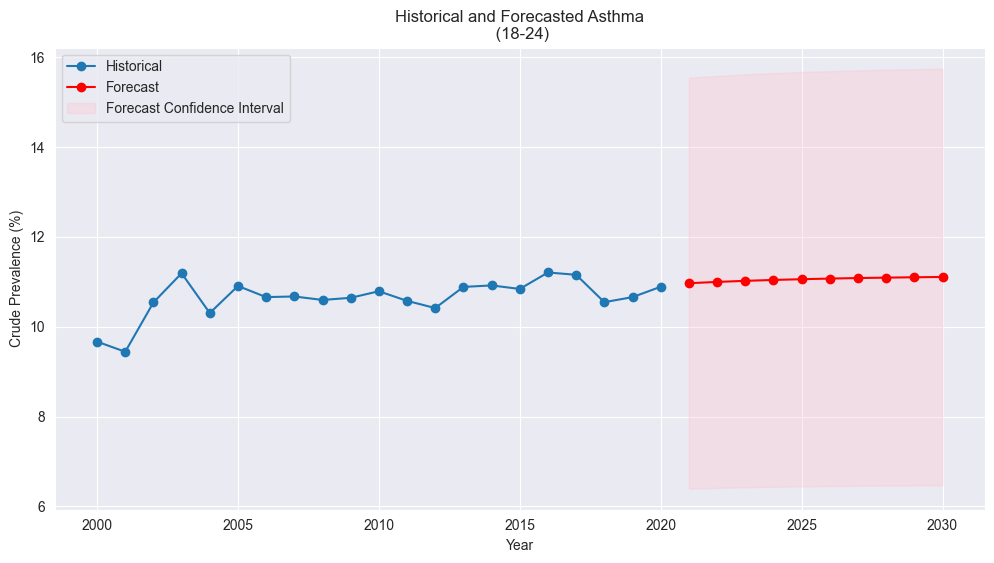

At age group: 25-34


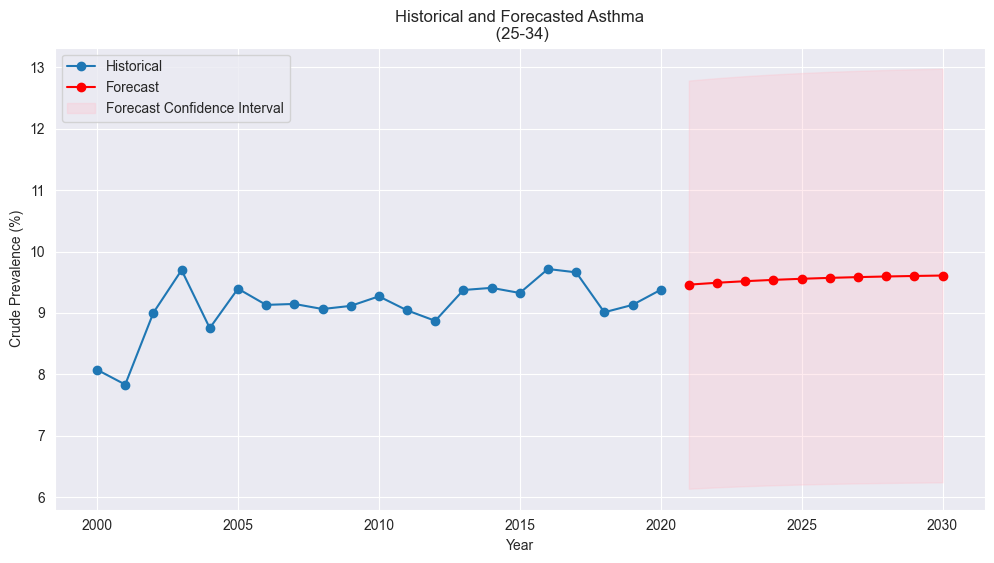

At age group: 35-44


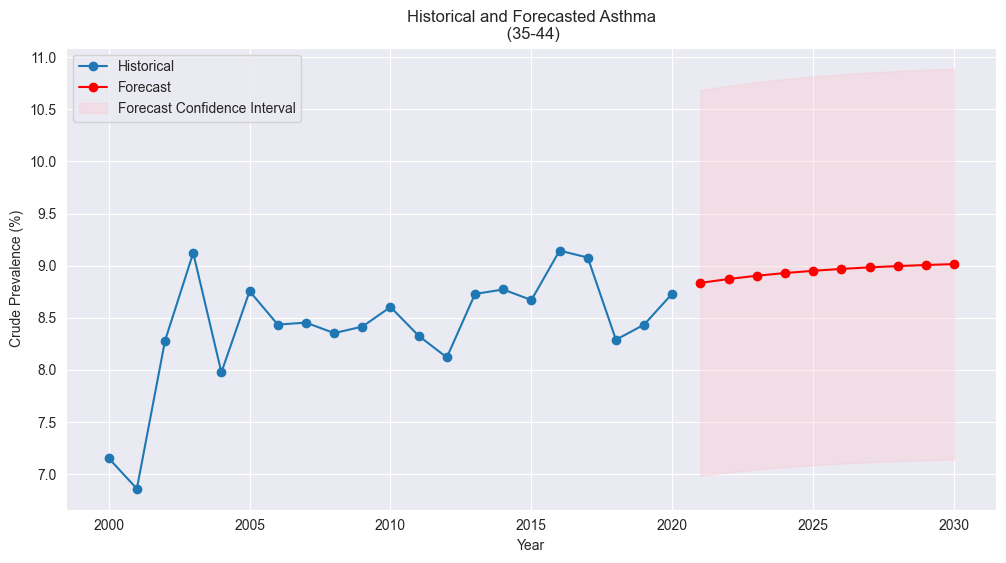

At age group: 45-54


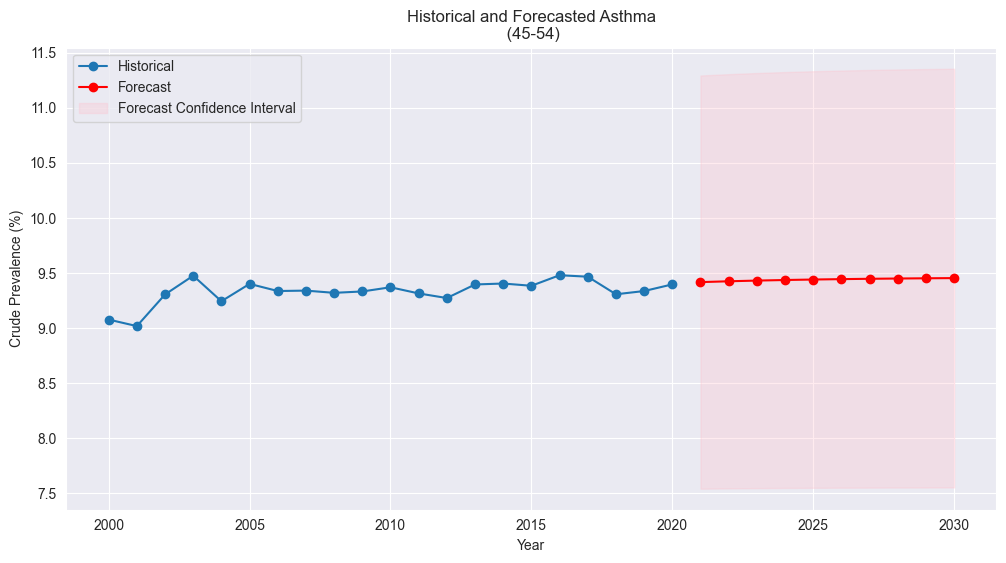

At age group: 55-64


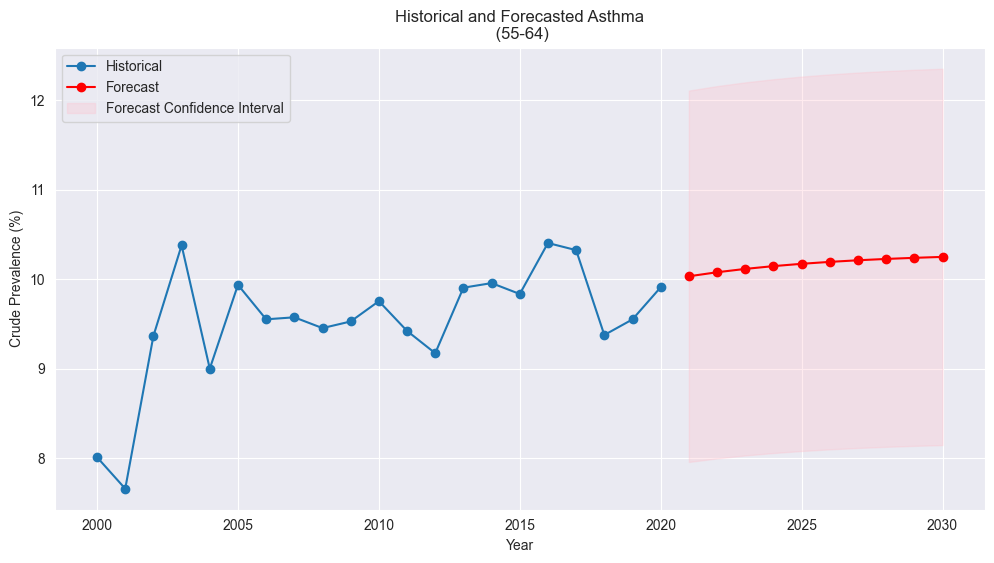

At age group: 65+


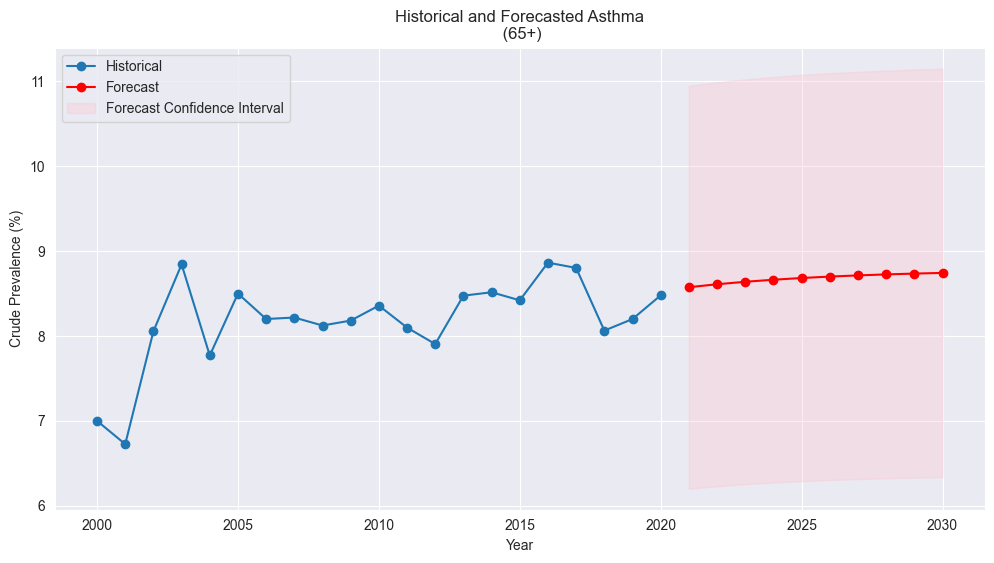

At age group: Overall


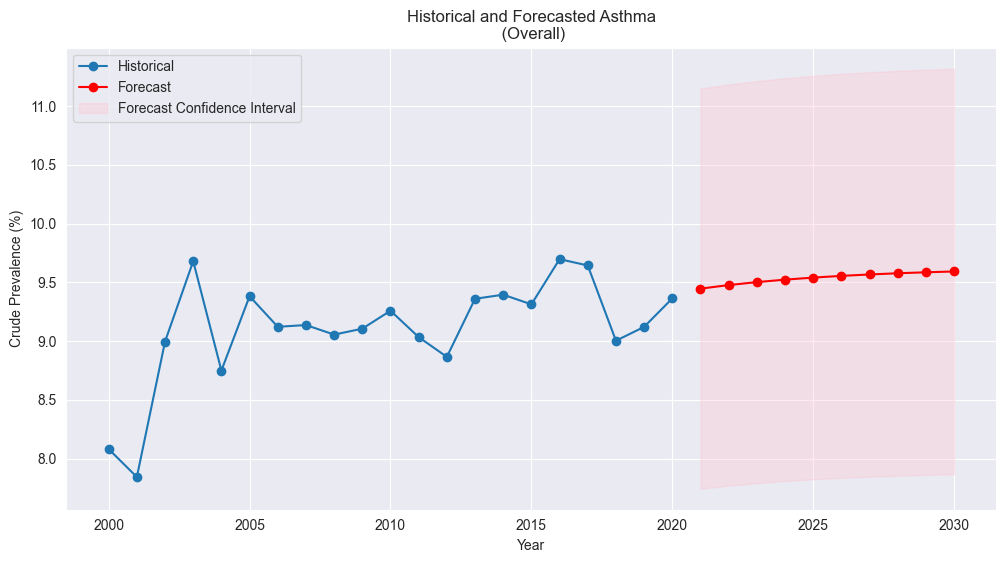

Analyzing variable: High Blood Pressure
At age group: 18-24


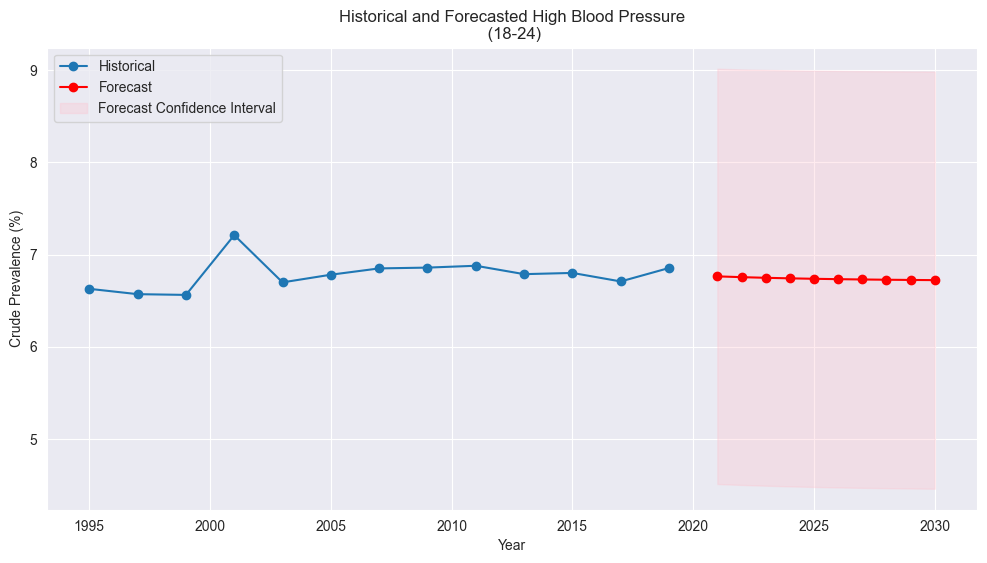

At age group: 25-34


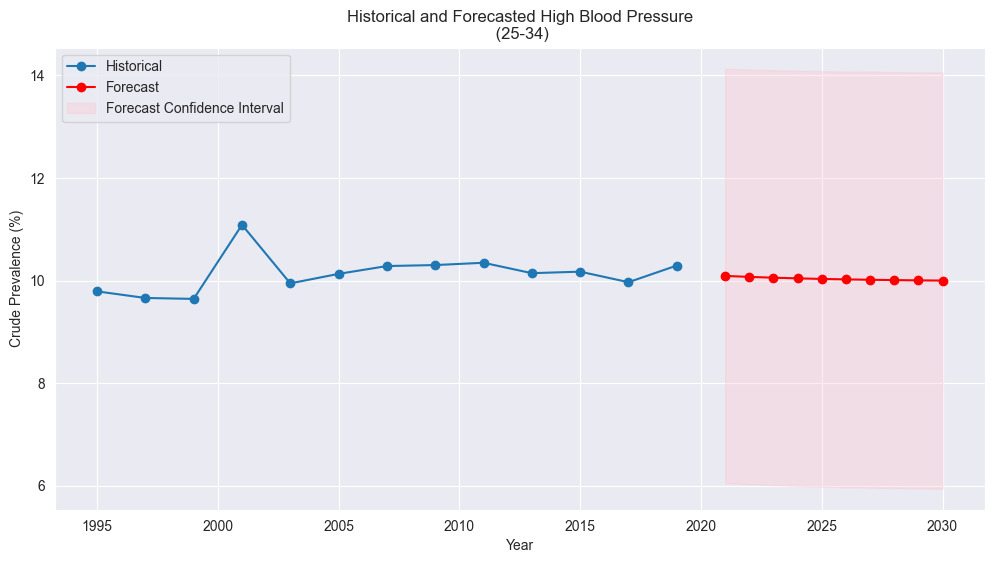

At age group: 35-44


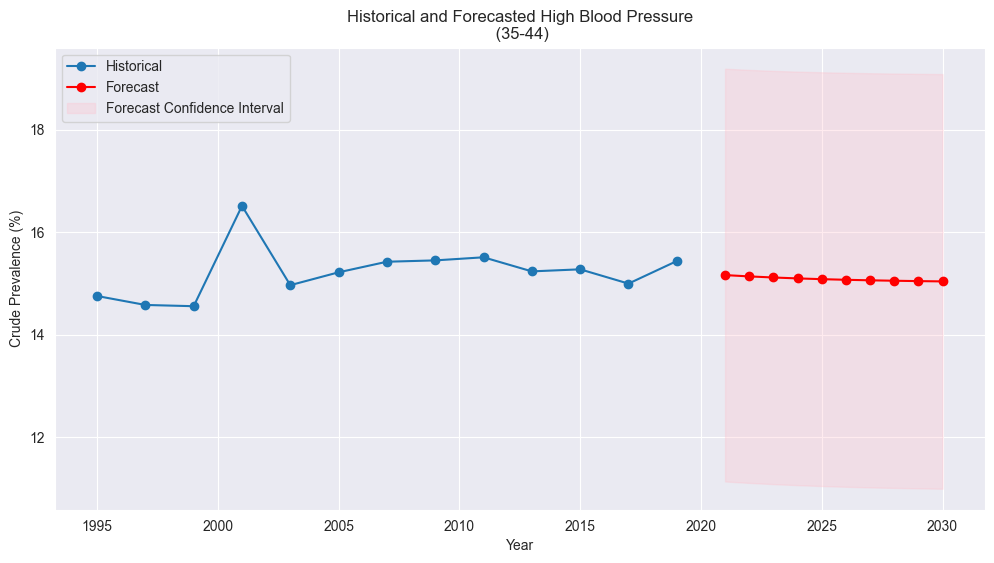

At age group: 45-54


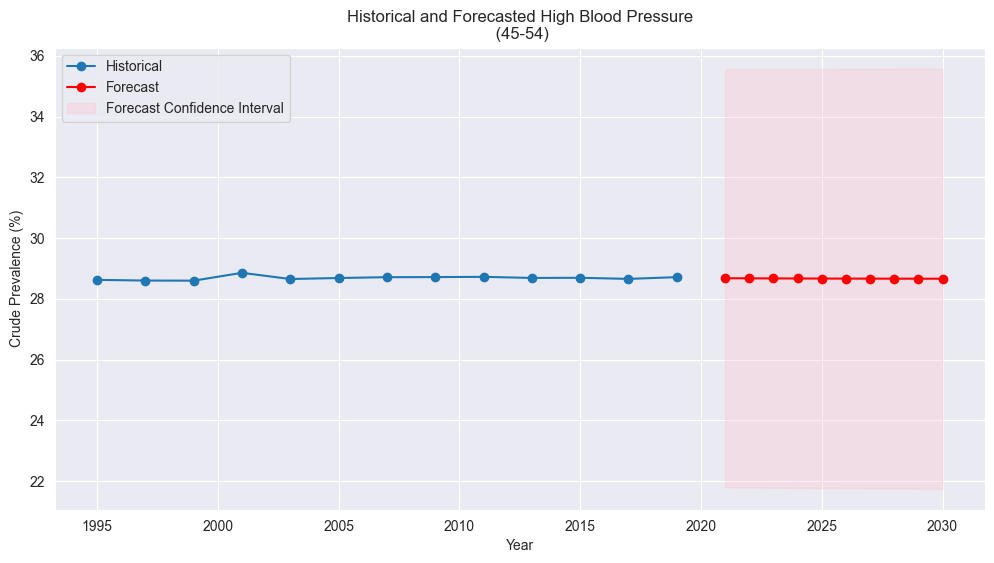

At age group: 55-64


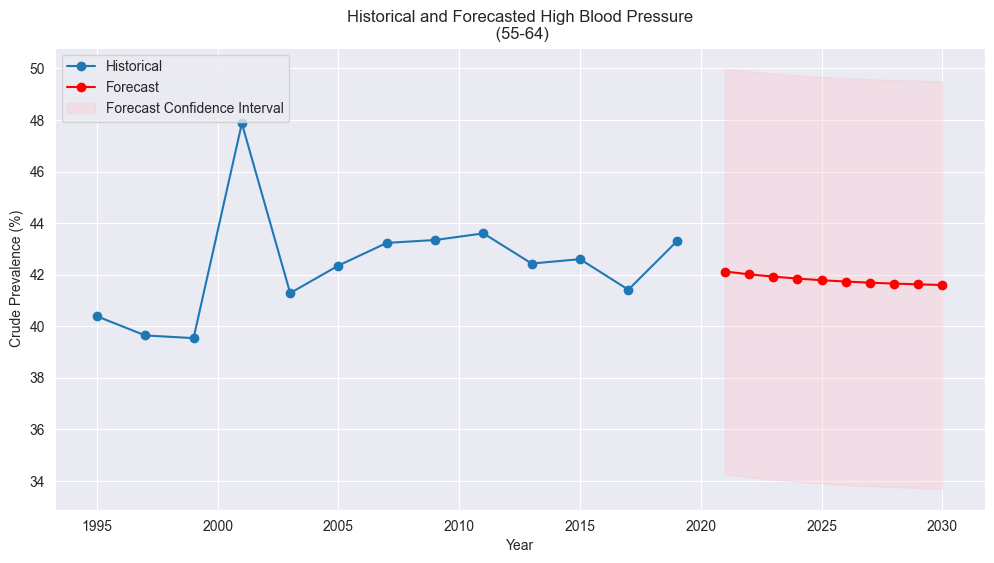

At age group: 65+


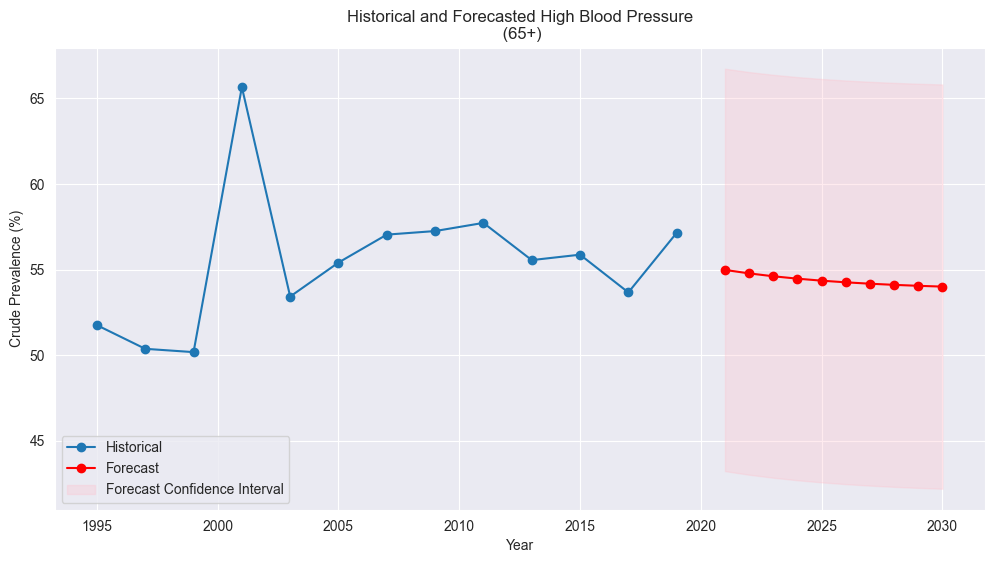

At age group: Overall


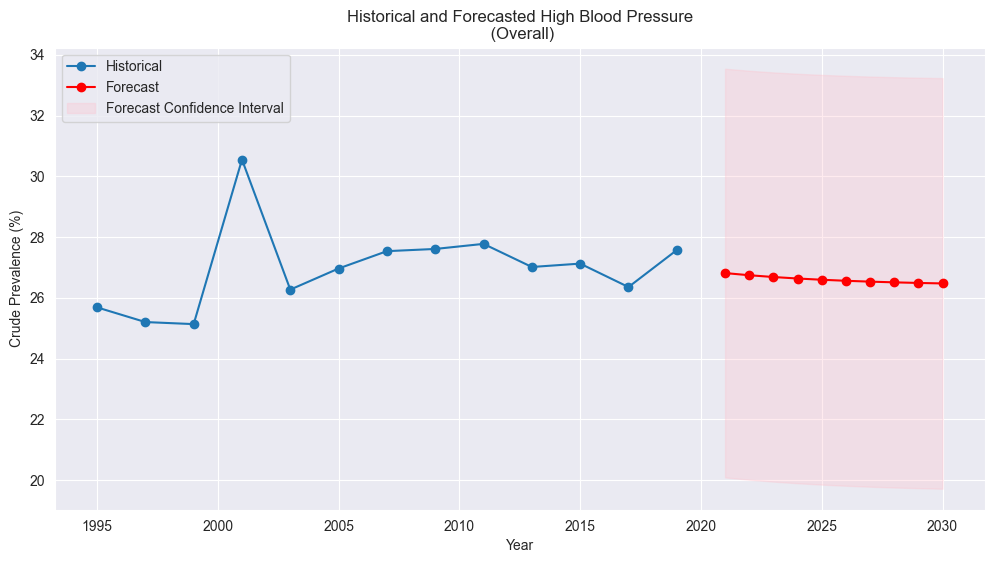

In [130]:

results = {}

age_groups = [
    "18-24", "25-34", "35-44", "45-54", "55-64", "65+", "Overall"
]

# combined data from EDA - merge of smoke estimate and health outcomes.
for var in combined_data['Topic'].unique():
    print(f"Analyzing variable: {var}")
    var_data = combined_data[combined_data['Topic'] == var]
    var_data = var_data[var_data['Response'] == 'Yes']

    if var == "Asthma":
        var_data = var_data[var_data["Question"] == "Adults who have been told they currently have asthma (variable calculated from one or more BRFSS questions)"]

    for age_group in age_groups:
        print(f"At age group: {age_group}")
        age_var_data = var_data[var_data['Break_Out'] == age_group]

        if var_data.empty:
            continue

        X = sm.add_constant(age_var_data['Avg_Smoke_Impact'])
        y = age_var_data['Data_value']

        # Check if there is enough data
        if len(age_var_data) < 3:
            print(f"Not enough data for {var}, {age_var_data}")
            continue

        # Fit the regression model
        regression_model = sm.OLS(y, X).fit()

        # Get predictions and prediction intervals for historical data
        predictions_historical = regression_model.get_prediction(X)
        pred_summary_historical = predictions_historical.summary_frame()
        pred_summary_historical['Fire_Year'] = age_var_data['Fire_Year'].values
        pred_summary_historical['Type'] = 'Historical'

        X_forecast = forecast_df[['Forecasted_Avg_Smoke_Impact']]
        X_forecast = X_forecast.rename(columns={'Forecasted_Avg_Smoke_Impact': 'Avg_Smoke_Impact'})
        X_forecast = sm.add_constant(X_forecast)

        # Predict future health metric
        predictions_forecast = regression_model.get_prediction(X_forecast)
        pred_summary_forecast = predictions_forecast.summary_frame()
        pred_summary_forecast['Fire_Year'] = forecast_df['Fire_Year']
        pred_summary_forecast['Type'] = 'Forecast'

        # Combine Historical and Forecasted Predictions

        combined_pred_df = pd.concat([pred_summary_historical, pred_summary_forecast], ignore_index=True)
        combined_pred_df = combined_pred_df.sort_values('Fire_Year')

        plt.figure(figsize=(12, 6))

        # Plot historical health metric
        plt.plot(
            combined_pred_df[combined_pred_df['Type'] == 'Historical']['Fire_Year'],
            combined_pred_df[combined_pred_df['Type'] == 'Historical']['mean'],
            label='Historical',
            marker='o'
        )

        # Plot forecasted health metric
        plt.plot(
            combined_pred_df[combined_pred_df['Type'] == 'Forecast']['Fire_Year'],
            combined_pred_df[combined_pred_df['Type'] == 'Forecast']['mean'],
            label='Forecast',
            marker='o',
            color='red'
        )

        # Fill between lower and upper confidence intervals for forecasted data
        plt.fill_between(
            combined_pred_df[combined_pred_df['Type'] == 'Forecast']['Fire_Year'],
            combined_pred_df[combined_pred_df['Type'] == 'Forecast']['obs_ci_lower'],
            combined_pred_df[combined_pred_df['Type'] == 'Forecast']['obs_ci_upper'],
            color='pink',
            alpha=0.3,
            label='Forecast Confidence Interval'
        )

        plt.title(f'Historical and Forecasted {var}\n ({age_group})')
        plt.xlabel('Year')
        plt.ylabel('Crude Prevalence (%)')
        plt.legend()
        plt.grid(True)
        plt.show()

        results_key = f"{var}_{age_group}"
        correlation = age_var_data[['Avg_Smoke_Impact', 'Data_value']].corr().iloc[0, 1]
        results[results_key] = {
            'regression_model': regression_model,
            'combined_pred_df': combined_pred_df,
            'correlation': correlation
        }


Now for each regression model (corresponding to each age group for each outcome), we print out the model statistics to see if we have any meaningful associations.

In [139]:
for key, result in results.items():
    print(f"Results for {key}:")
    #print(f"Correlation: {result['correlation']}")
    print(result['regression_model'].summary())

Results for Asthma_18-24:
                            OLS Regression Results                            
Dep. Variable:             Data_value   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                    0.8542
Date:                Sun, 24 Nov 2024   Prob (F-statistic):              0.367
Time:                        23:58:31   Log-Likelihood:                -44.403
No. Observations:                  21   AIC:                             92.81
Df Residuals:                      19   BIC:                             94.90
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const         

T:\School\DATA 512\Project Repo\data-512-course-project\venv\lib\site-packages\scipy\stats\_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=13 observations were given.
  return hypotest_fun_in(*args, **kwds)


From the model statistics we see that there is an unexpected negative association of smoke estimate and asthma prevalence - perhaps suggesting confounding variables for asthma that are not included in the model or an inaccurate smoke estimate.

We also observe that in high blood pressure prevalence, only a single model was statistically significant - for age groups 65+. Perhaps suggesting a need for targeted interventions for elderly individuals.


We then examine, in the overall group, how the prevalence of asthma and high blood pressure map against the smoke estimate. To do this, we normalized both the
smoke estimate and the prevalence using `sklearn`'s `MinMaxScalar` and plotted the outcome against the smoke estimate.

Analyzing variable: Asthma
At age group: Overall


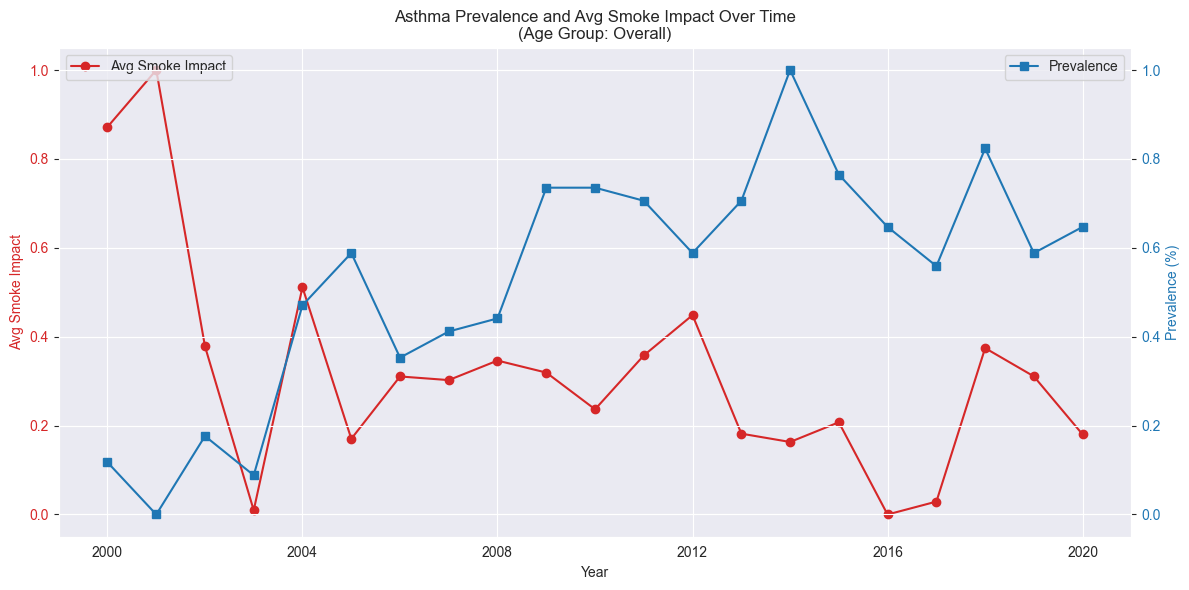

Correlation between Avg Smoke Impact and Prevalence for Asthma, Age Group Overall: -0.51
                            OLS Regression Results                            
Dep. Variable:             Prevalence   R-squared:                       0.264
Model:                            OLS   Adj. R-squared:                  0.225
Method:                 Least Squares   F-statistic:                     6.804
Date:                Sun, 24 Nov 2024   Prob (F-statistic):             0.0173
Time:                        23:31:18   Log-Likelihood:                -23.656
No. Observations:                  21   AIC:                             51.31
Df Residuals:                      19   BIC:                             53.40
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

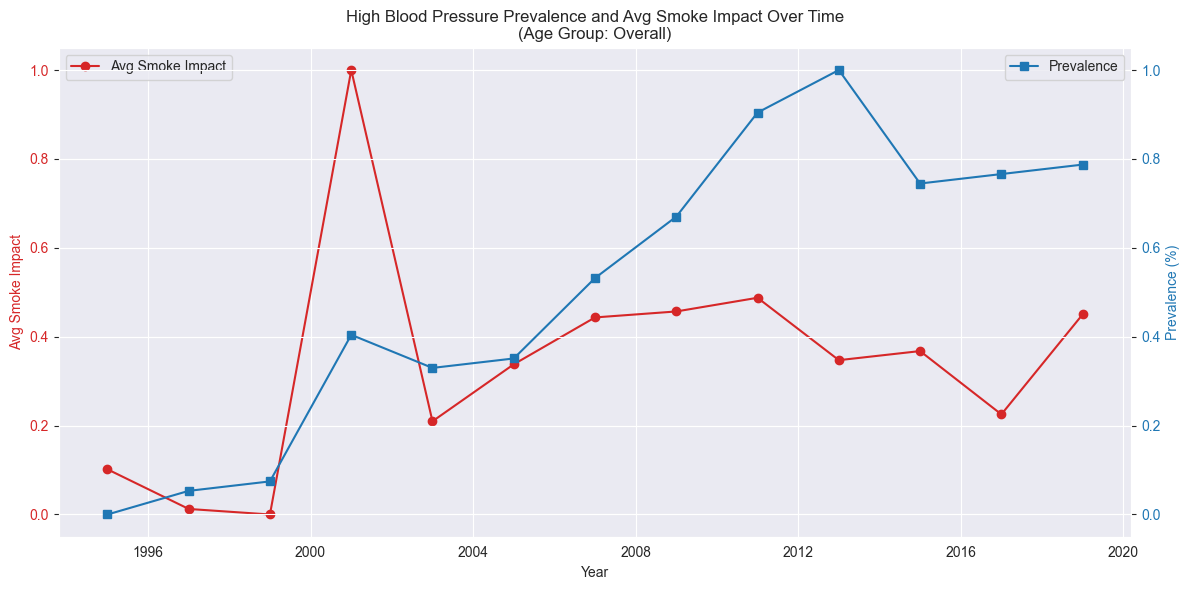

Correlation between Avg Smoke Impact and Prevalence for High Blood Pressure, Age Group Overall: 0.45
                            OLS Regression Results                            
Dep. Variable:             Prevalence   R-squared:                       0.198
Model:                            OLS   Adj. R-squared:                  0.126
Method:                 Least Squares   F-statistic:                     2.723
Date:                Sun, 24 Nov 2024   Prob (F-statistic):              0.127
Time:                        23:31:18   Log-Likelihood:                -31.399
No. Observations:                  13   AIC:                             66.80
Df Residuals:                      11   BIC:                             67.93
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------

T:\School\DATA 512\Project Repo\data-512-course-project\venv\lib\site-packages\scipy\stats\_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=13 observations were given.
  return hypotest_fun_in(*args, **kwds)


In [129]:
for var in combined_data['Topic'].unique():
    print(f"Analyzing variable: {var}")
    var_data = combined_data[combined_data['Topic'] == var]
    var_data = var_data[var_data['Response'] == 'Yes']
    
    if var == "Asthma":
        var_data = var_data[var_data["Question"] == "Adults who have been told they currently have asthma (variable calculated from one or more BRFSS questions)"]
    
    for age_group in ["Overall"]:#age_groups:
        print(f"At age group: {age_group}")
        age_var_data = var_data[var_data['Break_Out'] == age_group]

        if age_var_data.empty:
            continue

        # Merge with wildfire data
        merged_df = pd.merge(
            wildfire_df.to_pandas()[['Fire_Year', 'Avg_Smoke_Impact']],
            age_var_data[['Fire_Year', 'Data_value']],
            on='Fire_Year',
            how='inner'
        )

        merged_df = merged_df.rename(columns={'Data_value': 'Prevalence'})
        merged_df = merged_df.sort_values('Fire_Year')

        scaler = MinMaxScaler()
        merged_df[['Normalized_Smoke_Impact', 'Normalized_Prevalence']] = scaler.fit_transform(
            merged_df[['Avg_Smoke_Impact', 'Prevalence']]
        )

        merged_df["Fire_Year"] = pd.to_datetime(merged_df["Fire_Year"], format="%Y")
        
        # Plotting over time
        fig, ax1 = plt.subplots(figsize=(12, 6))
        color = 'tab:red'
        ax1.set_xlabel('Year')
        ax1.set_ylabel('Avg Smoke Impact', color=color)
        ax1.plot(merged_df['Fire_Year'], merged_df['Normalized_Smoke_Impact'], color=color, marker='o', label='Normalized Avg Smoke Impact')
        ax1.tick_params(axis='y', labelcolor=color)

        ax2 = ax1.twinx()
        color = 'tab:blue'
        ax2.set_ylabel('Prevalence (%)', color=color)
        ax2.plot(merged_df['Fire_Year'], merged_df['Normalized_Prevalence'], color=color, marker='s', label='Normalized Prevalence')
        ax2.tick_params(axis='y', labelcolor=color)

        plt.title(f'{var} Prevalence and Avg Smoke Impact Over Time\n(Age Group: {age_group})')
        fig.tight_layout()
        ax1.legend(loc='upper left')
        ax2.legend(loc='upper right')
        plt.grid(True)
        plt.show()

        # Correlation
        correlation = merged_df['Avg_Smoke_Impact'].corr(merged_df['Prevalence'])
        print(f'Correlation between Avg Smoke Impact and Prevalence for {var}, Age Group {age_group}: {correlation:.2f}')

        # Regression analysis
        X = sm.add_constant(merged_df['Avg_Smoke_Impact'])
        y = merged_df['Prevalence']
        regression_model = sm.OLS(y, X).fit()
        print(regression_model.summary())

We observe that in the asthma plot, the two diverge from each other. This once again suggests that there are some confounding variables / external factors that are playing a role in asthma prevalence or that the smoke estimate is inaccurate due to its simplicity.

We also observe in a similar divergence in the high blood pressure plot - suggesting the same issues we observed in the asthma plot.